# Hodgkin-Huxley Equations

Here we will solve the Hodgkin-Huxley differential equations. They are nonlinear ordinary differential equations that must be solved numerically or approximately. We can make use of the differential equation software from `scipy` that we explored previously. 

In [1]:
import numpy as np
import sys
import scipy.integrate
import scipy.optimize
import matplotlib.pyplot as plt

In [2]:

class HH:       
    def __init__( self, params ):
        self.params=params
        for iparam,param in params.items():
            setattr(self, iparam, params[iparam])
        
        # resting state is defined by V = 0, dn/dt = dm/dt = dh/dt = 0
        # calculate the resting conductances
        self.n_0 = self.alpha_n(0) / (self.alpha_n(0) + self.beta_n(0))
        self.m_0 = self.alpha_m(0) / (self.alpha_m(0) + self.beta_m(0))
        self.h_0 = self.alpha_h(0) / (self.alpha_h(0) + self.beta_h(0))
        self.V_0 = -90
        
        self.init_vals = np.array([ self.V_0, self.n_0, self.m_0, self.h_0 ])
        
    def set_param(self, parname, parval ):
        setattr( self, parname, parval )

    # Voltage-dependent rate constants (constant in time)

    def alpha_n(self, V):
        return 0.01 * (V + 10) / (np.exp((V + 10) / 10) - 1)

    def beta_n(self, V):
        return 0.125 * np.exp(V / 80)

    def alpha_m(self, V):
        return 0.1 * (V + 25)  / (np.exp((V + 25) / 10) - 1)

    def beta_m(self, V):
        return 4 * np.exp(V / 18)

    def alpha_h(self, V):
        return 0.07 * np.exp(V / 20)

    def beta_h(self, V):
        return 1 / (np.exp((V + 30) / 10) + 1)

    # Membrane current as function of time

    def I(self, t):
        # In a voltage clamp experiment I = 0, see page 522 of H-H article
        return 0
        # For propagated action potential see Eqs. (30,31) in the article

    # Hodgkin-Huxley equations

    def __call__(self, t, Vnmht):
        # returns flow vector given extended solution vector [V, n, m, h, t]
        V = Vnmht[0]
        n = Vnmht[1]
        m = Vnmht[2]
        h = Vnmht[3]
        flow = np.zeros(4)
        flow[0] = ( self.I(t) - self.g_K * n**4 * (V - self.V_K) - self.g_Na * m**3 * h * (V - self.V_Na) -
                    self.g_l * (V - self.V_l) ) / self.C_M
        flow[1] = self.alpha_n(V) * (1 - n) - self.beta_n(V) * n
        flow[2] = self.alpha_m(V) * (1 - m) - self.beta_m(V) * m
        flow[3] = self.alpha_h(V) * (1 - h) - self.beta_h(V) * h
        return flow


In [3]:
# Membrane constants from Table 3
params_hh = {
    'C_M':1.0,           # membrane capacitance per unit area
    'V_Na':-115,         # sodium Nernst potential
    'V_K':+12,           # potassium Nernst potential
    'V_l':-10.613,       # leakage potential
    'g_Na':120,          # sodium conductance
    'g_K':36,            # potassium conductance
    'g_l':0.3,           # leakage conductance
    }
hh = HH(params_hh)

print(" Hodgkin-Huxley Fig. 12")

print(" Initial depolarization V(0) =", hh.V_0, "mV")
t = 0
Vnmht = hh.init_vals
t_max = 6
dt = 0.01
dt_min, dt_max = [dt, dt]


res = scipy.integrate.solve_ivp(fun=hh,t_span=(0,t_max),
                                y0=hh.init_vals, 
                                vectorized=True,
                                atol=1e-8,rtol=1e-6,
                                method='RK45',
                                first_step = 0.001)
t = res.t
states=res.y

 Hodgkin-Huxley Fig. 12
 Initial depolarization V(0) = -90 mV


In [4]:
states[0,:] /= 100.

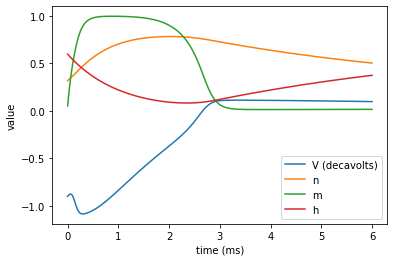

In [5]:
plt.plot(t, states.T)
plt.legend(labels=['V (decivolts)', 'n', 'm', 'h'])
plt.xlabel("time (ms)")
plt.ylabel("value")
plt.show()